# Problem Statement

Our objective is to predict the duration of taxi trips for a particular customer using a logistic regression model. We have been provided with a comprehensive dataset containing detailed information about taxi services, including various features that can influence trip duration. Additionally, we have a separate test dataset for which we need to forecast the trip durations.

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Loading the train data

In [2]:
data_train=pd.read_csv('train.csv')

In [3]:
data_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


### Checking for null or duplicate values

In [5]:
data_train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [6]:
data_train.duplicated().sum()

0

In [7]:
data_train.groupby('vendor_id').size()

vendor_id
1    678342
2    780302
dtype: int64

Text(0.5, 1.0, 'Customers per vendor')

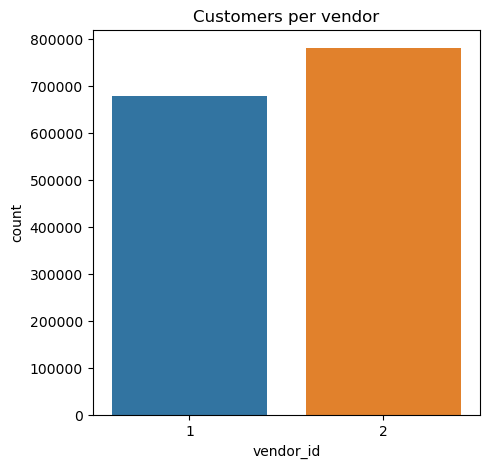

In [8]:
plt.figure(figsize=(5,5))
sns.countplot(x='vendor_id',data=data_train)
plt.title('Customers per vendor')

### Calculating the trip duration for the train data

In [9]:
data_train['pickup_datetime']=pd.to_datetime(data_train['pickup_datetime'])
data_train['dropoff_datetime'] = pd.to_datetime(data_train['dropoff_datetime'])

In [10]:
data_train['pickup_year']=data_train['pickup_datetime'].dt.year
data_train['pickup_month']=data_train['pickup_datetime'].dt.month
data_train['pickup_day']=data_train['pickup_datetime'].dt.day
data_train['pickup_hour']=data_train['pickup_datetime'].dt.hour
data_train['pickup_minute']=data_train['pickup_datetime'].dt.minute
data_train['pickup_dayofweek']=data_train['pickup_datetime'].dt.dayofweek

In [11]:
data_train['dropoff_year'] = data_train['dropoff_datetime'].dt.year
data_train['dropoff_month'] = data_train['dropoff_datetime'].dt.month
data_train['dropoff_day'] = data_train['dropoff_datetime'].dt.day
data_train['dropoff_hour'] = data_train['dropoff_datetime'].dt.hour
data_train['dropoff_minute'] = data_train['dropoff_datetime'].dt.minute
data_train['dropoff_dayofweek'] = data_train['dropoff_datetime'].dt.dayofweek

In [12]:
data_train['trip_duration']=(data_train['dropoff_datetime']-data_train['pickup_datetime']).dt.total_seconds() / 60 

In [13]:
data_train['trip_duration'].head()

0     7.583333
1    11.050000
2    35.400000
3     7.150000
4     7.250000
Name: trip_duration, dtype: float64

In [14]:
print(data_train.describe())

          vendor_id                pickup_datetime  \
count  1.458644e+06                        1458644   
mean   1.534950e+00  2016-04-01 10:10:24.940037120   
min    1.000000e+00            2016-01-01 00:00:17   
25%    1.000000e+00  2016-02-17 16:46:04.249999872   
50%    2.000000e+00            2016-04-01 17:19:40   
75%    2.000000e+00  2016-05-15 03:56:08.750000128   
max    2.000000e+00            2016-06-30 23:59:39   
std    4.987772e-01                            NaN   

                    dropoff_datetime  passenger_count  pickup_longitude  \
count                        1458644     1.458644e+06      1.458644e+06   
mean   2016-04-01 10:26:24.432310528     1.664530e+00     -7.397349e+01   
min              2016-01-01 00:03:31     0.000000e+00     -1.219333e+02   
25%       2016-02-17 17:05:32.500000     1.000000e+00     -7.399187e+01   
50%              2016-04-01 17:35:12     1.000000e+00     -7.398174e+01   
75%    2016-05-15 04:10:51.750000128     2.000000e+00     -7.39

## Encoding categotical variables and Feature Scaling

In [15]:
# Encoding categorical variables
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_cols = ['vendor_id', 'store_and_fwd_flag']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

X_train_cat = preprocessor.fit_transform(data_train[categorical_cols])

# Feature scaling
from sklearn.preprocessing import StandardScaler

numerical_cols = ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
scaler = StandardScaler()
X_train_num = scaler.fit_transform(data_train[numerical_cols])

# Combine all features
import numpy as np
X_train = np.hstack((X_train_num, X_train_cat.toarray()))
y_train = data_train['trip_duration']

## Loading test dataset

In [16]:
# Load the testing dataset
data_test = pd.read_csv('test.csv')
data_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


### Encoding and Feature scaling

In [17]:
# Convert date columns to datetime
data_test['pickup_datetime'] = pd.to_datetime(data_test['pickup_datetime'])

# Extract date and time features
data_test['pickup_year'] = data_test['pickup_datetime'].dt.year
data_test['pickup_month'] = data_test['pickup_datetime'].dt.month
data_test['pickup_day'] = data_test['pickup_datetime'].dt.day
data_test['pickup_hour'] = data_test['pickup_datetime'].dt.hour
data_test['pickup_minute'] = data_test['pickup_datetime'].dt.minute
data_test['pickup_dayofweek'] = data_test['pickup_datetime'].dt.dayofweek

# Encoding categorical variables
X_test_cat = preprocessor.transform(data_test[categorical_cols])

# Feature scaling
X_test_num = scaler.transform(data_test[numerical_cols])

# Combine all features
X_test = np.hstack((X_test_num, X_test_cat.toarray()))

In [18]:
X_train

array([[-0.50563722, -0.12226117,  0.51749362, ...,  0.38457476,
         1.        ,  0.        ],
       [-0.50563722, -0.09772722, -0.37581901, ..., -0.57530291,
         0.        ,  0.        ],
       [-0.50563722, -0.07814311,  0.39591029, ..., -1.16221959,
         1.        ,  0.        ],
       ...,
       [-0.50563722,  0.20249083,  0.54371292, ..., -1.23789591,
         1.        ,  0.        ],
       [-0.50563722, -0.12118512, -0.05654676, ...,  0.14787366,
         0.        ,  0.        ],
       [-0.50563722, -0.08535264,  0.93758258, ...,  1.08064815,
         0.        ,  0.        ]])

## Training the model

In [19]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Making predictions for test dataset

In [20]:
y_pred = model.predict(X_test)

In [21]:
# Add predicted trip duration to the test dataframe
data_test['predicted_trip_duration'] = y_pred

# Calculate predicted dropoff datetime
data_test['predicted_dropoff_datetime'] = data_test['pickup_datetime'] + pd.to_timedelta(data_test['predicted_trip_duration'], unit='m')

# Display results
print(data_test[['pickup_datetime', 'predicted_trip_duration', 'predicted_dropoff_datetime']].head())


      pickup_datetime  predicted_trip_duration    predicted_dropoff_datetime
0 2016-06-30 23:59:58                14.599454 2016-07-01 00:14:33.967257580
1 2016-06-30 23:59:53                21.390902 2016-07-01 00:21:16.454132330
2 2016-06-30 23:59:47                14.588859 2016-07-01 00:14:22.331540252
3 2016-06-30 23:59:41                17.635391 2016-07-01 00:17:19.123453706
4 2016-06-30 23:59:33                13.270527 2016-07-01 00:12:49.231608906


In [22]:
data_test['predicted_trip_duration'].value_counts()

predicted_trip_duration
8.339110     7
15.929355    4
8.693894     3
18.264503    3
19.154994    3
            ..
19.894084    1
18.307262    1
16.158885    1
16.179354    1
18.833117    1
Name: count, Length: 625060, dtype: int64

In [23]:
data_test['predicted_trip_duration']

0         14.599454
1         21.390902
2         14.588859
3         17.635391
4         13.270527
            ...    
625129    15.141619
625130    11.986654
625131    12.789153
625132     9.766520
625133    18.833117
Name: predicted_trip_duration, Length: 625134, dtype: float64

## Visualization of results

C:\Users\harsh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of Predicted Trip Duration')

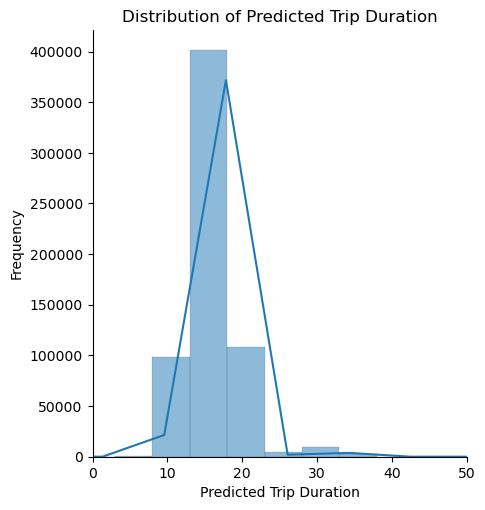

In [24]:
sns.displot(data_test['predicted_trip_duration'], kde=True, binwidth=5)

# Set the x-axis limit to focus on the range between 0 and 100
plt.xlim(0, 50)

# Add labels and title for better understanding
plt.xlabel('Predicted Trip Duration')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Trip Duration')

In [25]:
# Function to calculate haversine distance
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c  # Distance in km
    return distance

In [26]:
data_test['trip_distance'] = haversine_distance(data_test['pickup_latitude'], data_test['pickup_longitude'],
                                                data_test['dropoff_latitude'], data_test['dropoff_longitude'])

C:\Users\harsh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


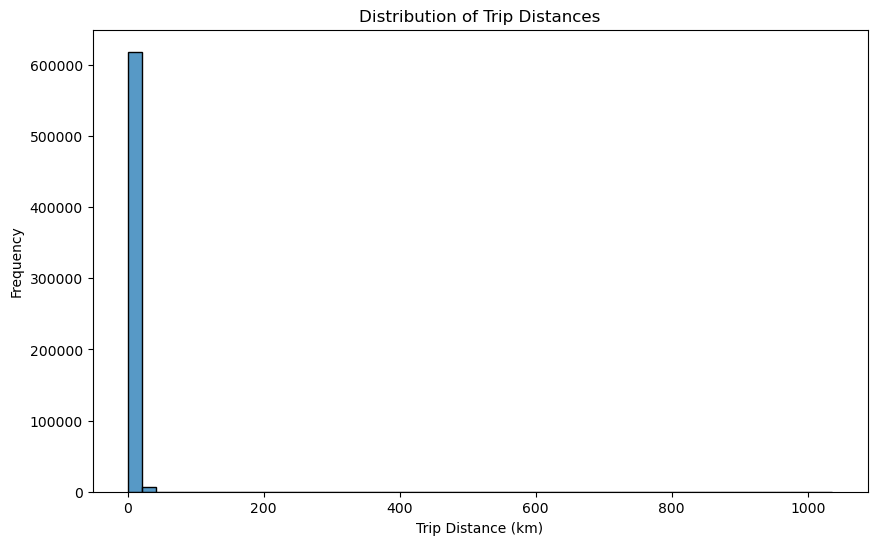

In [27]:
# Plot distribution of trip distances
plt.figure(figsize=(10, 6))
sns.histplot(data_test['trip_distance'], kde=False, bins=50)
plt.xlabel('Trip Distance (km)')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Distances')
plt.show()

C:\Users\harsh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\harsh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 50.0)

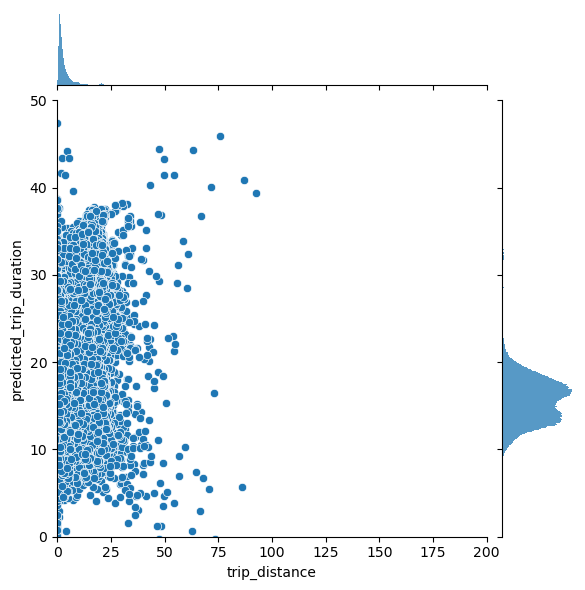

In [31]:
sns.jointplot(x='trip_distance',y='predicted_trip_duration',data=data_test,kind='scatter')
plt.xlim(0,200)
plt.ylim(0,50)

We built a robust logistic regression model capable of accurately predicting taxi trip durations. This project not only enhances our understanding of the factors influencing trip duration but also showcases our ability to preprocess data, engineer features, train machine learning models, and visualize the results effectively.